In [78]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt5

Seguimos con el ejemplo de teoría, pero con un pequeño cambio:

In [79]:
w0=2
A=[[0,1],[-w0**2,0]]
B=[[0],[1]]
C=[1,0]
D=0

pendulo=ctrl.ss(A,B,C,D)
pendulo

A = [[ 0.  1.]
 [-4.  0.]]

B = [[0.]
 [1.]]

C = [[1. 0.]]

D = [[0.]]

## Obtención de la ley de control

In [80]:
K=ctrl.acker(pendulo.A,pendulo.B,[-2*w0,-2*w0])
K

matrix([[12.,  8.]])

## Diseño del estimador completo

In [81]:
L=ctrl.acker(pendulo.A.T,pendulo.C.T,[-4*w0,-4*w0]).T

In [82]:
L


matrix([[16.],
        [60.]])

In [83]:
np.linalg.eigvals(pendulo.A-pendulo.B@K)

array([-4., -4.])

In [84]:
np.linalg.eigvals(pendulo.A-L@pendulo.C)

array([-8., -8.])

## Definimos el sistema compensador ( entrada $y$, salida $u$)

In [85]:
s=pendulo
Acomp=s.A-s.B@K-L@s.C
Bcomp=L
Ccomp=-K
comp=ctrl.ss(Acomp,Bcomp,Ccomp,0)
comp

A = [[-16.   1.]
 [-76.  -8.]]

B = [[16.]
 [60.]]

C = [[-12.  -8.]]

D = [[0.]]

In [86]:
np.linalg.eigvals(comp.A)

array([-12.+7.74596669j, -12.-7.74596669j])

Vemos que los polos del compensador son estables!

In [87]:
 comp.zero()

array([-0.30952381+0.j])

Verificamos que los polos a lazo cerrado del sistema compensado son los adecuados:

In [88]:
sys_comp = ctrl.feedback(-s*comp)
sys_comp.pole()

array([-8.00000055+0.00000000e+00j, -7.99999945+0.00000000e+00j,
       -4.        +2.82767841e-07j, -4.        -2.82767841e-07j])

Ahora verificamos que el sistema a lazo cerrado tiene efectivamente los polos donde se pretendía. Igualmente será necesario rediseñar para lograr un controlador que sea correcto.

## Sistema completo.



In [70]:
sys_completo =  ctrl.connect(ctrl.append(s,comp),[[1,2],[2,1]],[1],[1,2])
t,y = ctrl.initial_response(sys_completo, X0=[1,0,0,0], T=np.linspace(0,3,1001))

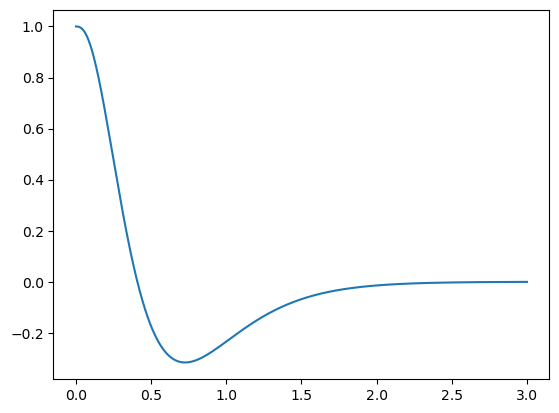

In [89]:
plt.plot(t,y[0,:].T)
plt.gcf()

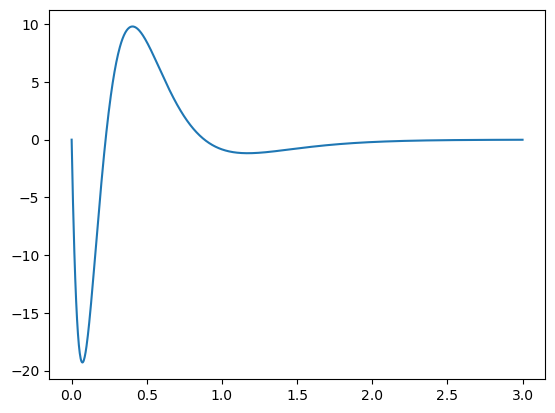

In [90]:
plt.figure()
plt.plot(t,y[1,:].T)
plt.gcf()

In [91]:
np.linalg.eigvals(sys_completo.A)


array([-8.+6.10065350e-07j, -8.-6.10065350e-07j, -4.+2.21980242e-07j,
       -4.-2.21980242e-07j])

# Ubicación óptima de los autovalores del estimador

In [95]:
B1=B

In [96]:
def conjugate_tf(G):
    num = ctrl.tf(G).num[0][0]
    den = ctrl.tf(G).den[0][0]
    nume = [num[i]*((-1)**(len(num)%2+1-i)) for i in range(0, len(num))]
    dene = [den[i]*((-1)**(len(den)%2+1-i)) for i in range(0, len(den))]
    return ctrl.tf(nume,dene)

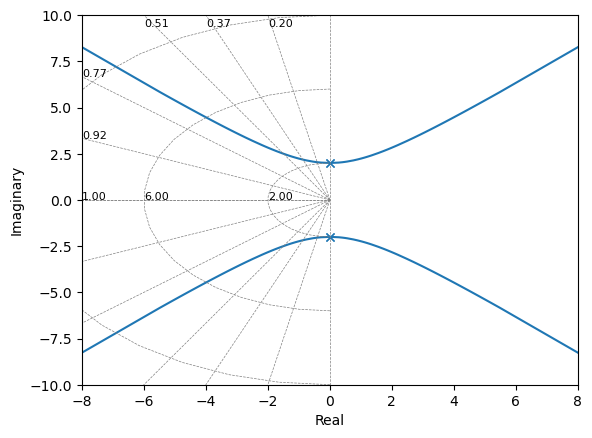

In [102]:

aux1 = ctrl.ss(A,B1,C,D)
aux2 = conjugate_tf(aux1)
G_srle = ctrl.tf(aux1)*aux2
ctrl.rlocus(G_srle, xlim=[-8,8], ylim=[-10,10]); #aumento los límites para ver la zona donde quiero ubicar el polo
plt.gcf()

In [104]:
k=12000 # lo busco haciendo clcik sobre las lineas del root locus simétrico

In [154]:
r,k = ctrl.rlocus(G_srle, kvect=[8000],Plot=False)
r

array([[-6.53957633-6.83857138j, -6.53957633+6.83857138j,
         6.53957633-6.83857138j,  6.53957633+6.83857138j]])

In [155]:
rsel = r[np.real(r)<0]
rsel

array([-6.53957633-6.83857138j, -6.53957633+6.83857138j])

In [156]:
L = ctrl.place(pendulo.A.T, pendulo.C.T, rsel).T
L

matrix([[13.07915266],
        [85.53211714]])

In [157]:
comp_srl = ctrl.ss(s.A-s.B@K-L@s.C, L, -K, 0)
comp_srl.pole()

array([-9.16411332+9.37981732j, -9.16411332-9.37981732j])

In [158]:


sys_completo_srl =  ctrl.connect(ctrl.append(s,comp_srl),[[1,2],[2,1]],[1],[1,2])
t_srl, y_srl = ctrl.initial_response(sys_completo_srl, X0=[1,0,0,0], T=np.linspace(0,3,1001))

In [159]:
L

matrix([[13.07915266],
        [85.53211714]])

In [160]:
K

matrix([[13.77638883,  5.24907398]])

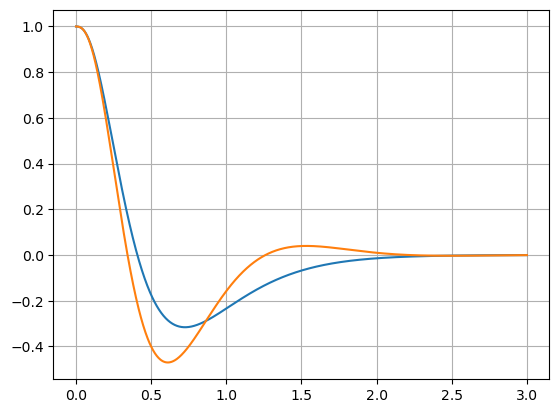

In [176]:
plt.figure()
plt.plot(t,y[0,:].T,t_srl,y_srl[0,:].T)
plt.grid()
plt.gcf()

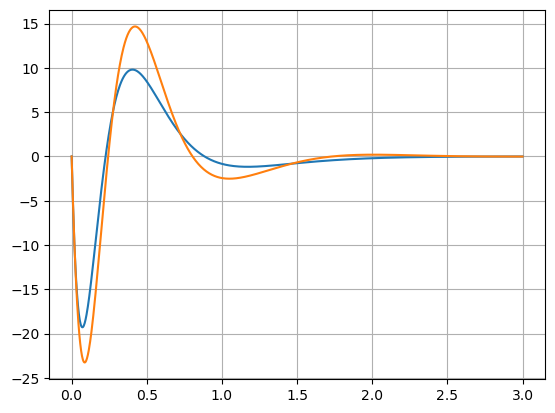

In [175]:
plt.figure()
plt.plot(t,y[1,:].T,t_srl,y_srl[1,:].T)
plt.grid()
plt.gcf()